In [2]:
# Natural Language Preprocessing with disaster tweets

In [3]:
!pip install transformers

## Importing libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
from datasets import Dataset
from transformers import BertTokenizer, BertForSequenceClassification


2024-08-07 11:41:32.622298: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 11:41:32.622410: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 11:41:32.751599: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Loading Dataset

In [5]:
train_file_path = "/kaggle/input/nlp-getting-started/train.csv"
test_file_path = "/kaggle/input/nlp-getting-started/test.csv"
submission_file_path = "/kaggle/input/nlp-getting-started/sample_submission.csv"

train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)


## Exploring Dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
train set info
: None



train set null value
: id             0
keyword       61
location    2533
text           0
target         0
dtype: int64



0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object





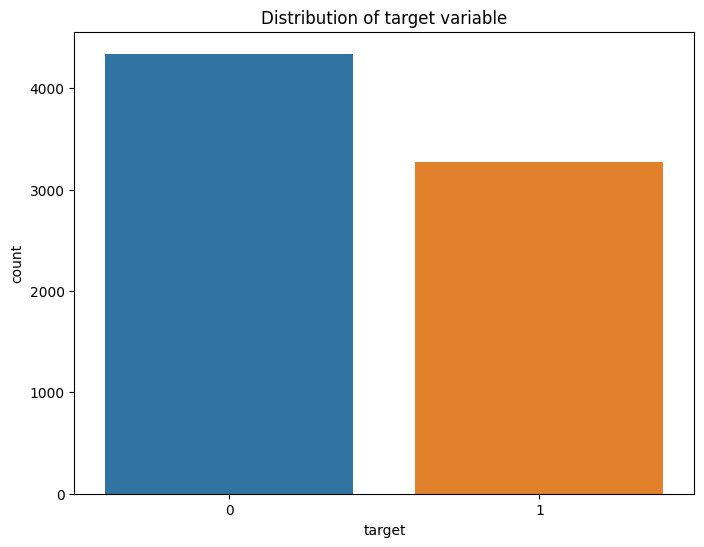

In [6]:
print(f"train set info\n: {train_df.info()}")
print("\n\n")
print(f"train set null value\n: {train_df.isnull().sum()}")
print("\n\n")
print(train_df['text'].head())
print("\n\n")
plt.figure(figsize = (8, 6))
sns.countplot(x = 'target', data = train_df)
plt.title('Distribution of target variable')
plt.show()



In [7]:
train_df['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

train_df, val_df = train_test_split(train_df, test_size = 0.2, random_state = 42)



## Loading pre-trained model

In [9]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## fine tune model

In [10]:
def tokenize_function(examples):
    tokenized = tokenizer(examples["text"], padding="max_length", truncation=True)
    if 'target' in examples:
        tokenized["labels"] = examples["target"]  # Add this line
    return tokenized



In [11]:
# Prepare datasets
train_dataset = Dataset.from_pandas(train_df[['text', 'target']])
train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=train_dataset.column_names)

val_dataset = Dataset.from_pandas(val_df[['text', 'target']])
val_dataset = val_dataset.map(tokenize_function, batched=True, remove_columns=val_dataset.column_names)

Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

In [12]:
from transformers import TrainingArguments, Trainer
import torch.nn as nn

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    report_to="none",
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
)

# Train the model
trainer.train()

Step,Training Loss
500,0.466900
1000,0.315900


TrainOutput(global_step=1143, training_loss=0.3698601860386806, metrics={'train_runtime': 1022.9621, 'train_samples_per_second': 17.86, 'train_steps_per_second': 1.117, 'total_flos': 4807038981427200.0, 'train_loss': 0.3698601860386806, 'epoch': 3.0})

In [14]:
# eval_results = trainer.evaluate()
# print(f"Validation loss: { eval_results['eval_loss']:.4f}")
# print(f"Validation Accuracy: {eval_results['eval_accuracy']:.4f}")

from sklearn.metrics import accuracy_score

# Evaluate the model
eval_results = trainer.evaluate()
print(f"Validation Loss: {eval_results['eval_loss']:.4f}")

# Predict on validation set
predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis=-1)

# Get true labels
true_labels = val_dataset['labels']

# Calculate accuracy
accuracy = accuracy_score(true_labels, preds)
print(f"Validation Accuracy: {accuracy:.4f}")

# For more detailed metrics
from sklearn.metrics import classification_report
print(classification_report(true_labels, preds))

Validation Loss: 0.5084
Validation Accuracy: 0.8385
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       874
           1       0.84      0.77      0.80       649

    accuracy                           0.84      1523
   macro avg       0.84      0.83      0.83      1523
weighted avg       0.84      0.84      0.84      1523



In [15]:
predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis = -1)
print(classification_report(val_df['target'], preds))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       874
           1       0.84      0.77      0.80       649

    accuracy                           0.84      1523
   macro avg       0.84      0.83      0.83      1523
weighted avg       0.84      0.84      0.84      1523



## Making predictions

In [16]:
test_dataset = Dataset.from_pandas(test_df[['text']])  # Note: only 'text' column here
test_dataset = test_dataset.map(tokenize_function, batched=True, remove_columns=test_dataset.column_names)

# train_dataset = Dataset.from_pandas(train_df[['text', 'target']])
# train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=train_dataset.column_names)

predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis = 1)


Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

## Submission

In [17]:
submission = pd.DataFrame({'id': test_df['id'], 'target': predicted_labels})
submission.to_csv('submission.csv', index=False)